# CAPSTONE PROJECT (Time Series Forecasting - Rossmann Store Sales)

### Goal: Explore data and predict the last 6 weeks of daily sales for 1,115 stores located across Germany.

### By -  Advaith Radhakrishnan

In [ ]:
import warnings
warnings.filterwarnings("ignore")
 
import numpy as np
import pandas as pd
from pandas import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline


# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [382]:
# importing train data to learn
train = pd.read_csv(r"C:\Users\aradhakris33\Downloads\train.csv", 
                    parse_dates = True, low_memory = False, index_col = 'Date')

# additional store data
store = pd.read_csv(r"C:\Users\aradhakris33\Downloads\store.csv", 
                    low_memory = False)
# time series as indexes
train.index

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

## Exploratory Data Analysis 

In [430]:

print("In total: ", train.shape)
train.head(5).append(train.tail(5))

In total:  (1017209, 8)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1
2013-01-01,1111,2,0,0,0,0,a,1
2013-01-01,1112,2,0,0,0,0,a,1
2013-01-01,1113,2,0,0,0,0,a,1
2013-01-01,1114,2,0,0,0,0,a,1


In [383]:
# data extraction (Extrating some data for further EDA)
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

# adding new variable
train['SalePerCustomer'] = train['Sales']/train['Customers']
train['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

On average customers spend about 9.50$ per day. Though there are days with Sales equal to zero.

### Missing values 
#### Closed stores and zero sales stores

In [384]:
# closed stores
train[(train.Open == 0) & (train.Sales == 0)].head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-07-31,292,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-31,876,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-30,292,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-30,876,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-29,292,3,0,0,0,1,0,1,2015,7,29,31,NaN


In [385]:
# opened stores with zero sales
zero_sales = train[(train.Open != 0) & (train.Sales == 0)]
print("In total: ", zero_sales.shape)
zero_sales.head(5)

In total:  (54, 13)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-05-15,971,5,0,0,1,0,0,1,2015,5,15,20,NaN
2015-03-26,674,4,0,0,1,0,0,0,2015,3,26,13,NaN
2015-02-05,699,4,0,0,1,1,0,0,2015,2,5,6,NaN
2014-10-01,708,3,0,0,1,1,0,0,2014,10,1,40,NaN
2014-09-22,357,1,0,0,1,0,0,0,2014,9,22,39,NaN


In [386]:
print("Closed stores and days which didn't have any sales won't be counted into the forecasts.")
train = train[(train["Open"] != 0) & (train['Sales'] != 0)]

print("In total: ", train.shape)

Closed stores and days which didn't have any sales won't be counted into the forecasts.
In total:  (844338, 13)


In [387]:
# additional information about the stores
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [388]:
# missing values?
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [389]:
# missing values in CompetitionDistance
store[pd.isnull(store.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [390]:
# fill NaN with a median value (skewed distribuion)
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)

In [391]:
# no promo = no information about the promo?
_ = store[pd.isnull(store.Promo2SinceWeek)]
_[_.Promo2 != 0].shape

(0, 10)

In [392]:
# replace NA's by 0
store.fillna(0, inplace = True)

In [393]:
print("Joining train set with an additional store information.")

# by specifying inner join we make sure that only those observations 
# that are present in both train and store sets are merged together
train_store = pd.merge(train, store, how = 'inner', on = 'Store')

print("In total: ", train_store.shape)
train_store.head()

Joining train set with an additional store information.
In total:  (844338, 22)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


### Store types

In [394]:
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


In [395]:
train_store.groupby('StoreType')['Customers', 'Sales'].sum()

,Customers,Sales
StoreType,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943


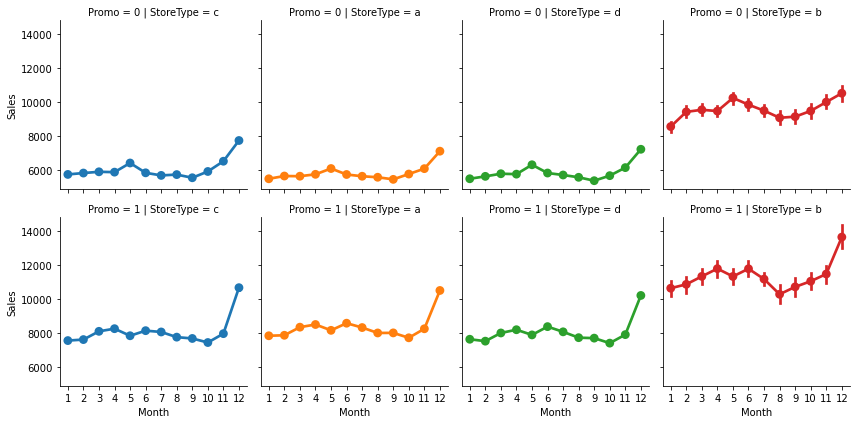

In [397]:
#Sales trends
g = sns.FacetGrid(train_store, col = "StoreType", hue = "StoreType", row = "Promo")
g.map(sns.pointplot, "Month", "Sales")

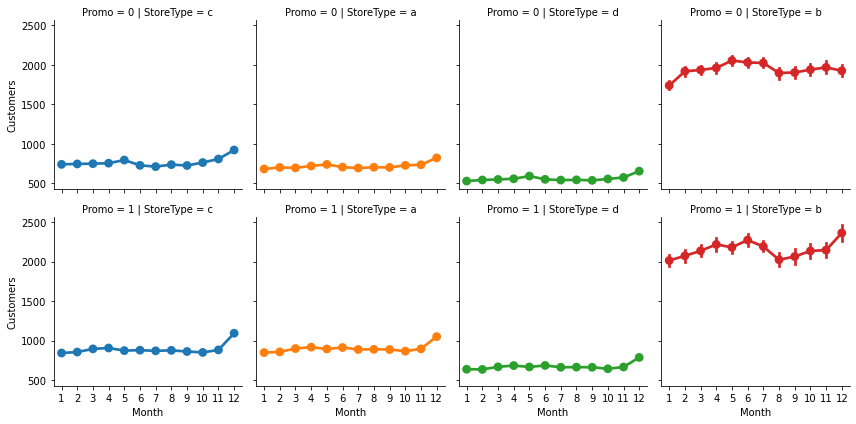

In [398]:
#Sales trends
g = sns.FacetGrid(train_store, col = "StoreType", hue = "StoreType", row = "Promo")
g.map(sns.pointplot, "Month", "Customers")

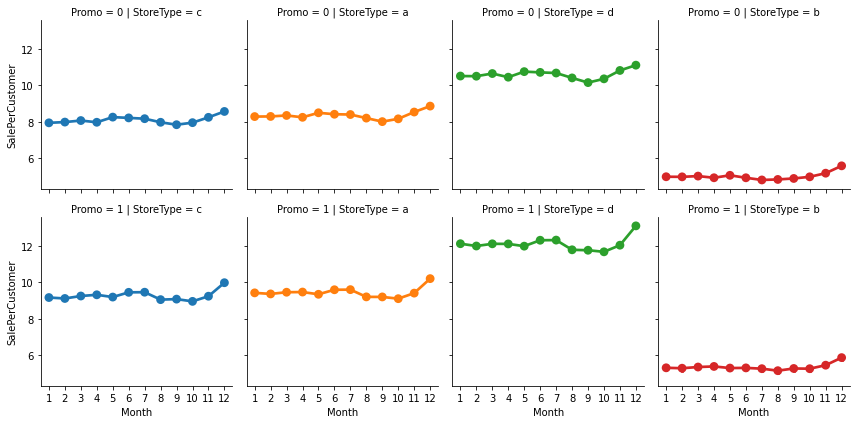

In [399]:
#Sale per customer trends
g = sns.FacetGrid(train_store, col = "StoreType", hue = "StoreType", row = "Promo")
g.map(sns.pointplot, "Month", "SalePerCustomer")

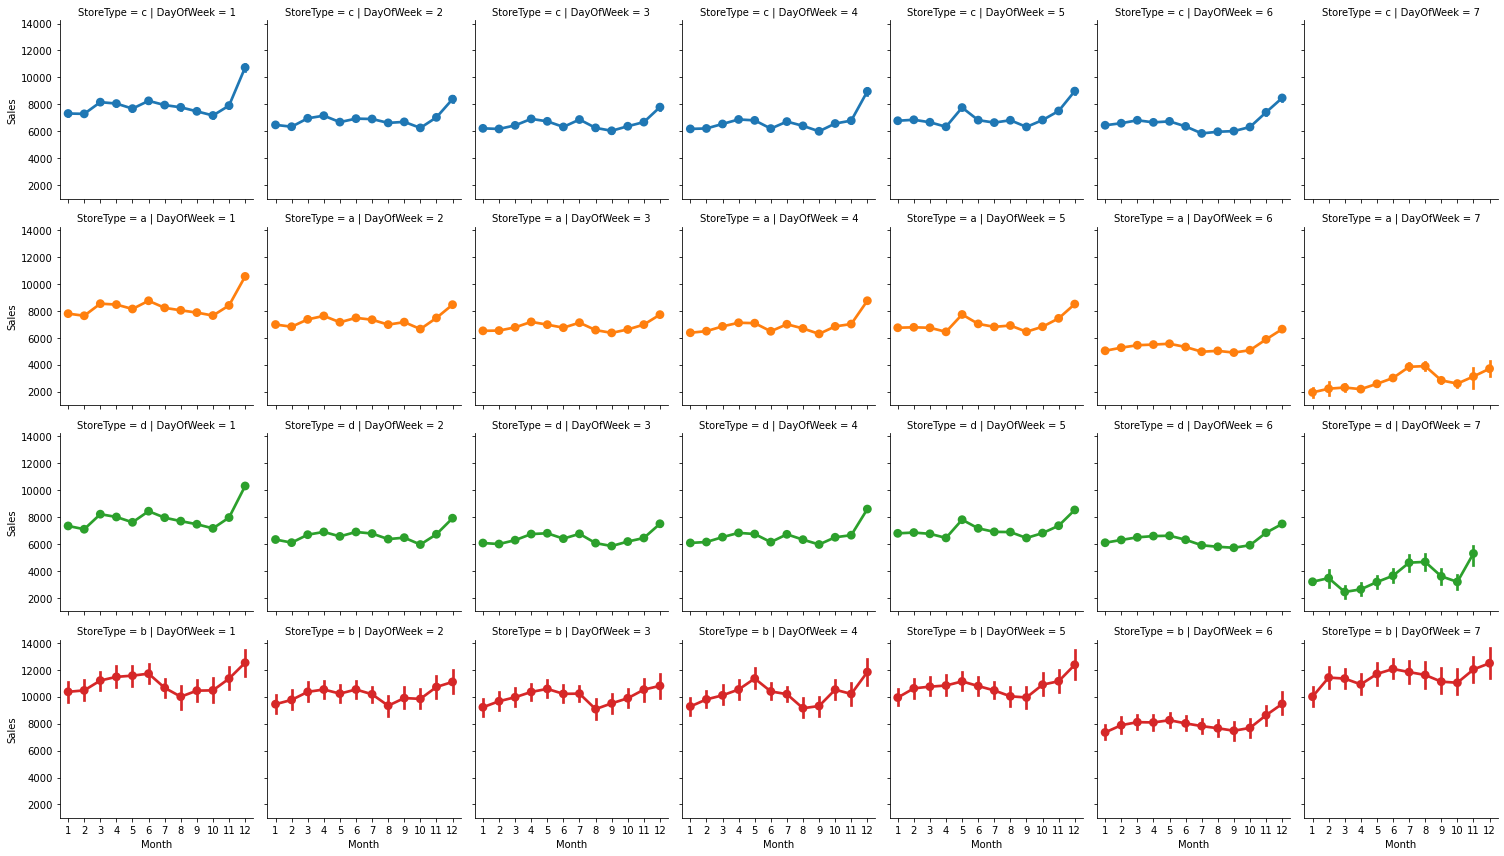

In [400]:
#Customers
g = sns.FacetGrid(train_store, col = "DayOfWeek", hue = "StoreType", row = "StoreType")
g.map(sns.pointplot, "Month", "Sales")

In [401]:
# stores which are opened on Sundays
train_store[(train_store.Open == 1) & (train_store.DayOfWeek == 7)]['Store'].unique()

array([  85,  122,  209,  259,  262,  274,  299,  310,  335,  353,  423,
        433,  453,  494,  512,  524,  530,  562,  578,  676,  682,  732,
        733,  769,  863,  867,  877,  931,  948, 1045, 1081, 1097, 1099],
      dtype=int64)

### Correlational Analysis

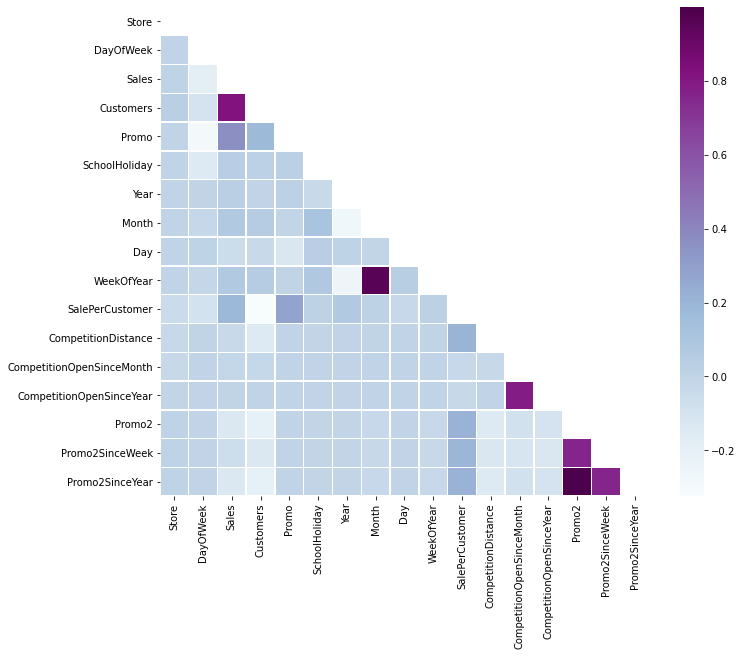

In [402]:
# Compute the correlation matrix 
# exclude 'Open' variable
corr_all = train_store.drop('Open', axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

## Time Series Analysis and Forecasting with VAR
#### Forecasting for the next 6 weeks for the first store

In [403]:
# importing data
df = pd.read_csv(r"C:\Users\aradhakris33\Downloads\train.csv", parse_dates=['Date'], index_col='Date')
print(df.shape)  # (123, 8)
df.tail()

# remove closed stores and those with no sales
df = df[(df["Open"] != 0) & (df['Sales'] != 0)]

# reverse to the order: from 2013 to 2015
df = df.sort_index(ascending = True)



(1017209, 8)


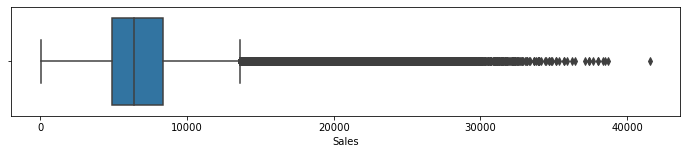

In [404]:
#OUTLIER DETECTION AND REMOVAL
import seaborn as sns
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=df['Sales'],whis=1.5)

In [405]:
q = df["Sales"].quantile(0.99)

In [406]:
df = df[df["Sales"] < q]

# STANDADIZE SALES AND CUSTOMERS VARIABLES

In [407]:
from sklearn import preprocessing
# Get column names first
names = df.columns
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
df['Sales'] = scaler.fit_transform(df['Sales'].values.reshape(-1, 1))
df['Customers'] = scaler.fit_transform(df['Customers'].values.reshape(-1, 1))

In [408]:
df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2013-01-01,1097,2,-0.308422,1.861419,1,0,a,1
2013-01-01,85,2,-0.936421,-0.356320,1,0,a,1
2013-01-01,259,2,0.012611,1.971459,1,0,a,1
2013-01-01,262,2,3.769781,6.009098,1,0,a,1
2013-01-01,274,2,-1.339696,-0.045950,1,0,a,1


In [409]:
#Creating data file with the store numbers mentioned( 1,3,8,9,13,25,29,31 and 46.)
df_1 = df[df['Store'] == 1]
df_2 = df[df['Store'] == 3]
df_3 = df[df['Store'] == 8]
df_4 = df[df['Store'] == 9]
df_5 = df[df['Store'] == 13]
df_6 = df[df['Store'] == 25]
df_7 = df[df['Store'] == 29]
df_8 = df[df['Store'] == 31]
df_9 = df[df['Store'] == 46]

In [410]:
df_1 = df_1[['Sales','Customers']]
df_2 = df_2[['Sales','Customers']]
df_3 = df_3[['Sales','Customers']]
df_4 = df_4[['Sales','Customers']]
df_5 = df_5[['Sales','Customers']]
df_6 = df_6[['Sales','Customers']]
df_7 = df_7[['Sales','Customers']]
df_8 = df_8[['Sales','Customers']]
df_9 = df_9[['Sales','Customers']]

# Checking for non-stationarity

In [411]:
df = df.drop(['Open'], axis=1)

In [412]:
df["StateHoliday"] = df['StateHoliday'].replace(['a','b','c'],[1,2,3])
df['StateHoliday'] = df['StateHoliday'].astype(int)

In [413]:

nobs = 42
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(835850, 7)
(42, 7)


In [414]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC', maxlag = 15)
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")   

In [415]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Store" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -48.2944
 No. Lags Chosen       = 15
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "DayOfWeek" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -21.4552
 No. Lags Chosen       = 15
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Sales" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level  

In [416]:
#Splitting the data into test and train sets for each of the stores
nobs = 42
train_1, test_1 = df_1[0:-nobs], df_1[-nobs:]
train_2, test_2 = df_2[0:-nobs], df_2[-nobs:]
train_3, test_3 = df_3[0:-nobs], df_3[-nobs:]
train_4, test_4 = df_4[0:-nobs], df_4[-nobs:]
train_5, test_5 = df_5[0:-nobs], df_5[-nobs:]
train_6, test_6 = df_6[0:-nobs], df_6[-nobs:]
train_7, test_7 = df_7[0:-nobs], df_7[-nobs:]
train_8, test_8 = df_8[0:-nobs], df_8[-nobs:]
train_9, test_9 = df_9[0:-nobs], df_9[-nobs:]

# VAR MODEL 1 (STORE 1)

In [417]:
model_1 = VAR(train_1)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model_1.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -7.534925223232146
BIC :  -7.497494785633768
FPE :  0.000534101248167136
HQIC:  -7.5204916131548645 

Lag Order = 2
AIC :  -7.558755666723193
BIC :  -7.496305356110041
FPE :  0.0005215240068402636
HQIC:  -7.534672581864129 

Lag Order = 3
AIC :  -7.613964338054555
BIC :  -7.526440939056995
FPE :  0.0004935120949417119
HQIC:  -7.58021003320109 

Lag Order = 4
AIC :  -7.670789969797837
BIC :  -7.558140080021196
FPE :  0.000466250496737545
HQIC:  -7.627342621511707 

Lag Order = 5
AIC :  -7.77555828120441
BIC :  -7.637728310319506
FPE :  0.00041987488125172647
HQIC:  -7.72239598743698 

Lag Order = 6
AIC :  -7.822915637557874
BIC :  -7.659851806385905
FPE :  0.0004004553841075396
HQIC:  -7.760016417263019 

Lag Order = 7
AIC :  -7.820188881476933
BIC :  -7.6318372210686825
FPE :  0.0004015504392174411
HQIC:  -7.747530674221503 

Lag Order = 8
AIC :  -7.844313901328271
BIC :  -7.630620252037584
FPE :  0.0003919810246414184
HQIC:  -7.761874566900118 

Lag Order = 9
AIC 

In [418]:
#As we can see, AIC drops to the lowest at lag order = 8
#Lets go with lag 8 model

In [419]:
model_fitted = model_1.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 12, Apr, 2021
Time:                     21:37:03
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -7.63062
Nobs:                     731.000    HQIC:                  -7.76187
Log likelihood:           826.609    FPE:                0.000391981
AIC:                     -7.84431    Det(Omega_mle):     0.000374366
--------------------------------------------------------------------
Results for equation Sales
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const               -0.288797         0.033163           -8.708           0.000
L1.Sales             0.621881         0.085028            7.314           0.000
L1.Customers         0.049965         0.115755            0.432 

In [420]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = train_1.values[-lag_order:]
forecast_input

8


array([[-0.36325027, -0.36478499],
       [-0.51655261, -0.38453584],
       [-0.949767  , -0.80494691],
       [-0.99016668, -0.68644178],
       [-0.97898462, -0.73440814],
       [-1.16330815, -0.82469777],
       [-1.15032254, -0.85573483],
       [-1.12579416, -0.91216584]])

In [421]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df_1.index[-nobs:], columns=df_1.columns + '_2d')
df_forecast

,Sales_2d,Customers_2d
Date,,
2015-06-13,-1.018980,-0.781422
2015-06-15,-1.022048,-0.761797
2015-06-16,-0.881090,-0.674562
2015-06-17,-0.908476,-0.698218
2015-06-18,-0.884527,-0.679101
2015-06-19,-0.962237,-0.728627
2015-06-20,-0.927845,-0.697319
2015-06-22,-0.889862,-0.665780
2015-06-23,-0.869046,-0.643247


In [422]:
#Calculating RMSE and MAPE values for store 1
mape = np.mean(np.abs(df_forecast['Sales_2d'].values - test_1['Sales'])/np.abs(test_1['Sales']))  # MAPE
rmse = np.mean((df_forecast['Sales_2d'].values - test_1['Sales'])**2)**.5  # RMSE
results = pd.DataFrame({'Model':['VAR Model 1'],'Store NO.':['1'], 'MAPE': [mape], 'RMSE': [rmse]})
results = results[['Model', 'Store NO.', 'RMSE', 'MAPE']]
results

,Model,Store NO.,RMSE,MAPE
0,VAR Model 1,1,0.258599,0.307607


# VAR MODEL (STORE 3)

In [423]:
model_2 = VAR(train_2)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model_2.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -4.62369190983327
BIC :  -4.586181881691458
FPE :  0.009816488378146651
HQIC:  -4.609225779181785 

Lag Order = 2
AIC :  -4.627938388580614
BIC :  -4.565355116482481
FPE :  0.009774894472483935
HQIC:  -4.603800972866098 

Lag Order = 3
AIC :  -4.658374774674856
BIC :  -4.570664793202645
FPE :  0.009481871011427535
HQIC:  -4.624544224095582 

Lag Order = 4
AIC :  -4.687953612980031
BIC :  -4.575063268322515
FPE :  0.009205527641971245
HQIC:  -4.644407998929747 

Lag Order = 5
AIC :  -4.8269281963775095
BIC :  -4.6888036454114586
FPE :  0.008011128262101848
HQIC:  -4.77364551105686 

Lag Order = 6
AIC :  -5.127803215806856
BIC :  -4.964390425172802
FPE :  0.005929616642747656
HQIC:  -5.064761371832386 

Lag Order = 7
AIC :  -5.164310083924565
BIC :  -4.975554829096794
FPE :  0.005717071882150486
HQIC:  -5.091486913935264 

Lag Order = 8
AIC :  -5.163609505008768
BIC :  -4.94945736935953
FPE :  0.005721109115509378
HQIC:  -5.080982761270163 

Lag Order = 9
AIC :  -5.1

In [424]:
#AIC is least for lag order = 9
model_fitted = model_2.fit(9)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 12, Apr, 2021
Time:                     21:37:06
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -4.92605
Nobs:                     728.000    HQIC:                  -5.07320
Log likelihood:          -147.676    FPE:                 0.00570945
AIC:                     -5.16566    Det(Omega_mle):      0.00542270
--------------------------------------------------------------------
Results for equation Sales
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.028109         0.022406            1.255           0.210
L1.Sales             1.070454         0.117421            9.116           0.000
L1.Customers        -1.383937         0.179351           -7.716 

In [425]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input_2 = train_2.values[-lag_order:]
forecast_input_2

9


array([[ 1.31261489,  0.65661641],
       [ 1.00059953,  0.48732336],
       [ 1.03486712,  0.53528972],
       [-0.7914147 , -0.5820444 ],
       [-0.08983102,  0.05844764],
       [ 0.11216736,  0.07537694],
       [-0.13564137, -0.07416525],
       [-0.41843911, -0.13059627],
       [-0.22906562, -0.18138418]])

In [426]:
# Forecast
fc_2 = model_fitted.forecast(y=forecast_input_2, steps=nobs)
df_forecast_2 = pd.DataFrame(fc_2, index=df_2.index[-nobs:], columns=df_2.columns + '_2d')
df_forecast_2

,Sales_2d,Customers_2d
Date,,
2015-06-13,-0.064261,-0.179312
2015-06-15,0.506570,0.212813
2015-06-16,0.294228,0.138307
2015-06-17,0.317907,0.170349
2015-06-18,0.220948,0.088874
2015-06-19,-0.048210,-0.059368
2015-06-20,-0.185231,-0.131134
2015-06-22,-0.008600,0.026461
2015-06-23,-0.099169,-0.028484


In [427]:
#Calculating RMSE and MAPE values for store 3
mape = np.mean(np.abs(df_forecast_2['Sales_2d'].values - test_2['Sales'])/np.abs(test_2['Sales']))  # MAPE
rmse = np.mean((df_forecast_2['Sales_2d'].values - test_2['Sales'])**2)**.5  # RMSE
tempResults = pd.DataFrame({'Model':['VAR Model 2'],'Store NO.':['3'], 'MAPE': [mape], 'RMSE': [rmse]})
results = pd.concat([results, tempResults])
results = results[['Model', 'Store NO.', 'RMSE', 'MAPE']]
results

,Model,Store NO.,RMSE,MAPE
0,VAR Model 1,1,0.258599,0.307607
0,VAR Model 2,3,0.652441,0.947666


# VAR MODEL 3 (STORE 8)

In [428]:
model_3 = VAR(train_3)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model_3.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -4.863742912205517
BIC :  -4.826431166251702
FPE :  0.007721529415705878
HQIC:  -4.849357792677649 

Lag Order = 2
AIC :  -5.040199085637668
BIC :  -4.9779470560944485
FPE :  0.0064724622784273775
HQIC:  -5.016197011429298 

Lag Order = 3
AIC :  -5.1447972294710915
BIC :  -5.057552072646633
FPE :  0.005829662933085713
HQIC:  -5.11115661081741 

Lag Order = 4
AIC :  -5.311590453789123
BIC :  -5.19929914099399
FPE :  0.004934084991493522
HQIC:  -5.268289623557277 

Lag Order = 5
AIC :  -5.463128622841634
BIC :  -5.325737939492698
FPE :  0.004240287569344288
HQIC:  -5.410145836151692 

Lag Order = 6
AIC :  -5.959013647772926
BIC :  -5.796470192491743
FPE :  0.0025824769073919166
HQIC:  -5.896327081616492 

Lag Order = 7
AIC :  -5.976522605149466
BIC :  -5.788772788855065
FPE :  0.0025376640938698245
HQIC:  -5.904110358005916 

Lag Order = 8
AIC :  -6.027809987325232
BIC :  -5.81480003232129
FPE :  0.0024108077617954024
HQIC:  -5.945650078775566 

Lag Order = 9
AIC :  

In [429]:
#As we can see, AIC drops to the lowest at lag order = 8
#Lets go with lag 8 model
model_fitted_3 = model_3.fit(8)
model_fitted_3.summary()


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 12, Apr, 2021
Time:                     21:37:08
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -5.81480
Nobs:                     734.000    HQIC:                  -5.94565
Log likelihood:           163.204    FPE:                 0.00241081
AIC:                     -6.02781    Det(Omega_mle):      0.00230290
--------------------------------------------------------------------
Results for equation Sales
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const               -0.190663         0.035228           -5.412           0.000
L1.Sales             0.923248         0.102712            8.989           0.000
L1.Customers        -1.181874         0.143871           -8.215 

In [430]:
# Get the lag order
lag_order = model_fitted_3.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input_3 = train_3.values[-lag_order:]
forecast_input_3

8


array([[ 0.4140828 ,  0.64250865],
       [-0.32898268, -0.11366696],
       [-1.25060031, -0.87830723],
       [-0.24313337,  0.01612437],
       [-0.55659157, -0.13906092],
       [-0.56633078, -0.2434583 ],
       [-0.40148567,  0.12616486],
       [-0.48408858, -0.19549194]])

In [431]:
# Forecast
fc_3 = model_fitted_3.forecast(y=forecast_input_3, steps=nobs)
df_forecast_3 = pd.DataFrame(fc_3, index=df_3.index[-nobs:], columns=df_3.columns + '_2d')
df_forecast_3

,Sales_2d,Customers_2d
Date,,
2015-06-13,-1.099091,-0.805106
2015-06-15,0.142750,0.151876
2015-06-16,0.081398,0.099708
2015-06-17,-0.125458,-0.046284
2015-06-18,0.196135,0.330156
2015-06-19,-0.352638,-0.174655
2015-06-20,-0.897445,-0.632139
2015-06-22,-0.236367,-0.033177
2015-06-23,-0.402019,-0.152082


In [432]:
#Calculating RMSE and MAPE values for store 8
mape = np.mean(np.abs(df_forecast_3['Sales_2d'].values - test_3['Sales'])/np.abs(test_3['Sales']))  # MAPE
rmse = np.mean((df_forecast_3['Sales_2d'].values - test_3['Sales'])**2)**.5  # RMSE
tempResults = pd.DataFrame({'Model':['VAR Model 3'],'Store NO.':['8'], 'MAPE': [mape], 'RMSE': [rmse]})
results = pd.concat([results, tempResults])
results = results[['Model', 'Store NO.', 'RMSE', 'MAPE']]
results

,Model,Store NO.,RMSE,MAPE
0,VAR Model 1,1,0.258599,0.307607
0,VAR Model 2,3,0.652441,0.947666
0,VAR Model 3,8,0.639908,2.309548


# VAR MODEL 4( STORE 9)

In [433]:
model_4 = VAR(train_4)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model_4.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -6.69337207076486
BIC :  -6.655862042623048
FPE :  0.0012390975080162553
HQIC:  -6.678905940113375 

Lag Order = 2
AIC :  -6.747418963015554
BIC :  -6.684835690917421
FPE :  0.001173906100565267
HQIC:  -6.723281547301037 

Lag Order = 3
AIC :  -6.752485028098464
BIC :  -6.664775046626253
FPE :  0.0011679749151779855
HQIC:  -6.71865447751919 

Lag Order = 4
AIC :  -6.758062277886045
BIC :  -6.645171933228529
FPE :  0.0011614804824843531
HQIC:  -6.714516663835761 

Lag Order = 5
AIC :  -6.79291478149176
BIC :  -6.654790230525709
FPE :  0.0011216995861707015
HQIC:  -6.7396320961711105 

Lag Order = 6
AIC :  -6.84895732088462
BIC :  -6.685544530250565
FPE :  0.0010605688962715043
HQIC:  -6.78591547691015 

Lag Order = 7
AIC :  -6.848573138218964
BIC :  -6.659817883391193
FPE :  0.0010609807448077487
HQIC:  -6.775749968229664 

Lag Order = 8
AIC :  -6.855687135128054
BIC :  -6.641534999478816
FPE :  0.0010534653441354226
HQIC:  -6.773060391389449 

Lag Order = 9
AIC :  

In [434]:
#As we can see, AIC drops to the lowest at lag order = 9
#Lets go with lag 9 model
model_fitted_4 = model_4.fit(9)
model_fitted_4.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 12, Apr, 2021
Time:                     21:37:11
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -6.62258
Nobs:                     728.000    HQIC:                  -6.76973
Log likelihood:           469.861    FPE:                 0.00104665
AIC:                     -6.86219    Det(Omega_mle):     0.000994082
--------------------------------------------------------------------
Results for equation Sales
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.485719         0.215233            2.257           0.024
L1.Sales             0.993341         0.117143            8.480           0.000
L1.Customers        -1.097216         0.231810           -4.733 

In [435]:
# Get the lag order
lag_order = model_fitted_4.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input_4 = train_4.values[-lag_order:]
forecast_input_4

9


array([[ 1.23794763,  0.04998298],
       [ 1.14271982,  0.08384159],
       [ 1.07129897,  0.23902689],
       [ 0.1229887 , -0.38453584],
       [ 0.38522589, -0.22935055],
       [ 0.07826049, -0.32810482],
       [-0.34882181, -0.62154611],
       [-0.164859  , -0.47482547],
       [-0.1396092 , -0.47482547]])

In [436]:
# Forecast
fc_4 = model_fitted_4.forecast(y=forecast_input_4, steps=nobs)
df_forecast_4 = pd.DataFrame(fc_4, index=df_4.index[-nobs:], columns=df_4.columns + '_2d')
df_forecast_4

,Sales_2d,Customers_2d
Date,,
2015-06-13,-0.160923,-0.504325
2015-06-15,0.123292,-0.346655
2015-06-16,0.145134,-0.332591
2015-06-17,0.025152,-0.417704
2015-06-18,0.152485,-0.342146
2015-06-19,0.063993,-0.384538
2015-06-20,-0.022559,-0.431246
2015-06-22,-0.006684,-0.409579
2015-06-23,-0.073067,-0.441269


In [437]:
#Calculating RMSE and MAPE values for store 9
mape = np.mean(np.abs(df_forecast_4['Sales_2d'].values - test_4['Sales'])/np.abs(test_4['Sales']))  # MAPE
rmse = np.mean((df_forecast_4['Sales_2d'].values - test_4['Sales'])**2)**.5  # RMSE
tempResults = pd.DataFrame({'Model':['VAR Model 4'],'Store NO.':['9'], 'MAPE': [mape], 'RMSE': [rmse]})
results = pd.concat([results, tempResults])
results = results[['Model', 'Store NO.', 'RMSE', 'MAPE']]
results

,Model,Store NO.,RMSE,MAPE
0,VAR Model 1,1,0.258599,0.307607
0,VAR Model 2,3,0.652441,0.947666
0,VAR Model 3,8,0.639908,2.309548
0,VAR Model 4,9,0.683608,1.266797


# VAR MODEL 5 (STORE 13)

In [438]:
model_5 = VAR(train_5)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model_5.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -6.941596958779723
BIC :  -6.896341866717379
FPE :  0.000966724724778813
HQIC:  -6.923950701894057 

Lag Order = 2
AIC :  -6.946247821845062
BIC :  -6.870721959340589
FPE :  0.0009622397151401193
HQIC:  -6.9167958615845455 

Lag Order = 3
AIC :  -6.968599194771089
BIC :  -6.862721578018064
FPE :  0.0009409723509514703
HQIC:  -6.927308130126884 

Lag Order = 4
AIC :  -7.008442371379954
BIC :  -6.872131657059342
FPE :  0.0009042205484693921
HQIC:  -6.955278650027112 

Lag Order = 5
AIC :  -7.121902921087323
BIC :  -6.955077404155214
FPE :  0.0008072367718302527
HQIC:  -7.056832838446605 

Lag Order = 6
AIC :  -7.188077186571503
BIC :  -6.990654798029473
FPE :  0.0007555522560216183
HQIC:  -7.111066884863828 

Lag Order = 7
AIC :  -7.18791718603878
BIC :  -6.959815490686692
FPE :  0.0007556795622227687
HQIC:  -7.098932653332224 

Lag Order = 8
AIC :  -7.201222475733643
BIC :  -6.942358669904738
FPE :  0.0007456999351209912
HQIC:  -7.100229544982929 

Lag Order = 9
AIC

In [439]:
#As we can see, AIC drops to the lowest at lag order = 9
#Lets go with lag 9 model
model_fitted_5 = model_5.fit(9)
model_fitted_5.summary()


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 12, Apr, 2021
Time:                     21:37:19
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -6.91290
Nobs:                     570.000    HQIC:                  -7.08957
Log likelihood:           473.154    FPE:                0.000744678
AIC:                     -7.20261    Det(Omega_mle):     0.000697409
--------------------------------------------------------------------
Results for equation Sales
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const               -0.512544         0.376571           -1.361           0.173
L1.Sales             0.301843         0.130003            2.322           0.020
L1.Customers         0.206445         0.295750            0.698 

In [440]:
# Get the lag order
lag_order = model_fitted_5.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input_5 = train_5.values[-lag_order:]
forecast_input_5

9


array([[-0.33800047, -1.06452959],
       [-0.47038155, -0.88395033],
       [-0.0068674 , -0.86137793],
       [-1.08755875, -1.23382263],
       [-1.00423442, -1.22817953],
       [-1.16835811, -1.25639504],
       [-1.18422941, -1.35232777],
       [-0.77157557, -1.2874321 ],
       [-1.18134372, -1.32129071]])

In [441]:
# Forecast
fc_5 = model_fitted_5.forecast(y=forecast_input_5, steps=nobs)
df_forecast_5 = pd.DataFrame(fc_5, index=df_5.index[-nobs:], columns=df_5.columns + '_5d')
df_forecast_5

,Sales_5d,Customers_5d
Date,,
2015-06-13,-0.628849,-1.076327
2015-06-15,-0.432738,-0.981621
2015-06-16,-0.298125,-0.919117
2015-06-17,-0.390853,-0.970763
2015-06-18,-0.536668,-1.042484
2015-06-19,-0.725334,-1.102877
2015-06-20,-0.655008,-1.052887
2015-06-22,-0.748998,-1.085834
2015-06-23,-0.789723,-1.103187


In [442]:
#Calculating RMSE and MAPE values for store 13
mape = np.mean(np.abs(df_forecast_5['Sales_5d'].values - test_5['Sales'])/np.abs(test_5['Sales']))  # MAPE
rmse = np.mean((df_forecast_5['Sales_5d'].values - test_5['Sales'])**2)**.5  # RMSE
tempResults = pd.DataFrame({'Model':['VAR Model 5'],'Store NO.':['13'], 'MAPE': [mape], 'RMSE': [rmse]})
results = pd.concat([results, tempResults])
results = results[['Model', 'Store NO.', 'RMSE', 'MAPE']]
results

,Model,Store NO.,RMSE,MAPE
0,VAR Model 1,1,0.258599,0.307607
0,VAR Model 2,3,0.652441,0.947666
0,VAR Model 3,8,0.639908,2.309548
0,VAR Model 4,9,0.683608,1.266797
0,VAR Model 5,13,0.643536,17.462935


# VAR MODEL 6 (STORE 23)

In [443]:
model_6 = VAR(train_6)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model_6.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -3.6661809542567556
BIC :  -3.6268203823872383
FPE :  0.025573954554434855
HQIC:  -3.6509577082349107 

Lag Order = 2
AIC :  -3.685245807002757
BIC :  -3.6195708457326026
FPE :  0.025091019095210224
HQIC:  -3.659843413532584 

Lag Order = 3
AIC :  -3.8328265163999835
BIC :  -3.7407777013763917
FPE :  0.021648369824348
HQIC:  -3.7972206140300493 

Lag Order = 4
AIC :  -3.847913086615246
BIC :  -3.729430731204149
FPE :  0.02132425515247351
HQIC:  -3.802079220746345 

Lag Order = 5
AIC :  -3.8856987304697186
BIC :  -3.740722924605571
FPE :  0.020533588295509966
HQIC:  -3.8296123528678088 

Lag Order = 6
AIC :  -3.9486997110879956
BIC :  -3.7771703201159705
FPE :  0.019279928954063236
HQIC:  -3.882336179393906 

Lag Order = 7
AIC :  -3.9466350369768093
BIC :  -3.748491700487339
FPE :  0.019319871647918655
HQIC:  -3.8699696142126965 

Lag Order = 8
AIC :  -3.9506693267863637
BIC :  -3.7258514574419612
FPE :  0.01924221070571656
HQIC:  -3.8636771808588843 

Lag Order = 9

In [444]:
#As we can see, AIC drops to the lowest at lag order = 9
#Lets go with lag 9 model
model_fitted_6 = model_6.fit(9)
model_fitted_6.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 12, Apr, 2021
Time:                     21:37:21
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -3.70023
Nobs:                     684.000    HQIC:                  -3.85444
Log likelihood:          -551.599    FPE:                  0.0192210
AIC:                     -3.95178    Det(Omega_mle):       0.0181961
--------------------------------------------------------------------
Results for equation Sales
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.530047         0.240874            2.201           0.028
L1.Sales             0.927224         0.140182            6.614           0.000
L1.Customers        -0.715098         0.157143           -4.551 

In [445]:
# Get the lag order
lag_order = model_fitted_6.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input_6 = train_6.values[-lag_order:]
forecast_input_6

9


array([[2.44055944, 2.86589069],
       [2.59963316, 3.06057769],
       [2.34966016, 2.81228122],
       [0.72645887, 1.35636101],
       [1.67512985, 2.53294769],
       [1.0756275 , 2.08149956],
       [0.91258595, 1.83038154],
       [0.75387294, 1.78523673],
       [0.81122605, 1.66391004]])

In [446]:
# Forecast
fc_6 = model_fitted_6.forecast(y=forecast_input_6, steps=nobs)
df_forecast_6 = pd.DataFrame(fc_6, index=df_6.index[-nobs:], columns=df_6.columns + '_6d')
df_forecast_6

,Sales_6d,Customers_6d
Date,,
2015-06-13,0.827995,1.629798
2015-06-15,1.593615,2.296061
2015-06-16,1.610685,2.302537
2015-06-17,1.619712,2.290749
2015-06-18,1.788939,2.468384
2015-06-19,1.700932,2.413274
2015-06-20,1.452402,2.198899
2015-06-22,1.568264,2.362402
2015-06-23,1.384119,2.210912


In [447]:
#Calculating RMSE and MAPE values for store 25
mape = np.mean(np.abs(df_forecast_6['Sales_6d'].values - test_6['Sales'])/np.abs(test_6['Sales']))  # MAPE
rmse = np.mean((df_forecast_6['Sales_6d'].values - test_6['Sales'])**2)**.5  # RMSE
tempResults = pd.DataFrame({'Model':['VAR Model 6'],'Store NO.':['25'], 'MAPE': [mape], 'RMSE': [rmse]})
results = pd.concat([results, tempResults])
results = results[['Model', 'Store NO.', 'RMSE', 'MAPE']]
results

,Model,Store NO.,RMSE,MAPE
0,VAR Model 1,1,0.258599,0.307607
0,VAR Model 2,3,0.652441,0.947666
0,VAR Model 3,8,0.639908,2.309548
0,VAR Model 4,9,0.683608,1.266797
0,VAR Model 5,13,0.643536,17.462935
0,VAR Model 6,25,0.748206,1.034749


# VAR MODEL 7 (STORE 29)

In [448]:
model_7 = VAR(train_7)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model_7.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -5.901929636564506
BIC :  -5.864419608422694
FPE :  0.002734164029645215
HQIC:  -5.887463505913021 

Lag Order = 2
AIC :  -5.908649277241181
BIC :  -5.846066005143047
FPE :  0.0027158539151839623
HQIC:  -5.884511861526664 

Lag Order = 3
AIC :  -5.92252622482838
BIC :  -5.834816243356169
FPE :  0.0026784284163711685
HQIC:  -5.888695674249107 

Lag Order = 4
AIC :  -5.954134854202641
BIC :  -5.841244509545125
FPE :  0.002595094398571242
HQIC:  -5.9105892401523565 

Lag Order = 5
AIC :  -5.973579660138646
BIC :  -5.835455109172595
FPE :  0.002545125965574109
HQIC:  -5.9202969748179965 

Lag Order = 6
AIC :  -6.017622578591216
BIC :  -5.854209787957162
FPE :  0.0024354710829434896
HQIC:  -5.954580734616746 

Lag Order = 7
AIC :  -6.058200565343558
BIC :  -5.869445310515787
FPE :  0.002338632330114243
HQIC:  -5.9853773953542575 

Lag Order = 8
AIC :  -6.064105684825216
BIC :  -5.849953549175978
FPE :  0.002324875543877842
HQIC:  -5.9814789410866105 

Lag Order = 9
AIC 

In [449]:
#As we can see, AIC drops to the lowest at lag order = 8
#Lets go with lag 8 model
model_fitted = model_7.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 12, Apr, 2021
Time:                     21:37:23
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -5.84995
Nobs:                     729.000    HQIC:                  -5.98148
Log likelihood:           175.554    FPE:                 0.00232488
AIC:                     -6.06411    Det(Omega_mle):      0.00222012
--------------------------------------------------------------------
Results for equation Sales
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.564657         0.190521            2.964           0.003
L1.Sales             0.444288         0.154355            2.878           0.004
L1.Customers         0.024113         0.314351            0.077 

In [450]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input_7 = train_7.values[-lag_order:]
forecast_input_7

8


array([[ 1.44932451,  0.47885871],
       [ 1.36744303,  0.27570705],
       [ 0.5691887 , -0.10238076],
       [ 0.1799811 , -0.2321721 ],
       [ 0.01405386, -0.4042867 ],
       [-0.14357702, -0.52279183],
       [-0.18433741, -0.45225306],
       [-0.2250978 , -0.48893322]])

In [451]:
# Forecast
fc_7 = model_fitted.forecast(y=forecast_input_7, steps=nobs)
df_forecast_7 = pd.DataFrame(fc_7, index=df_7.index[-nobs:], columns=df_7.columns + '_2d')
df_forecast_7

,Sales_2d,Customers_2d
Date,,
2015-06-13,0.125983,-0.328855
2015-06-15,0.295933,-0.243666
2015-06-16,0.293469,-0.241955
2015-06-17,0.155696,-0.315730
2015-06-18,0.114944,-0.323089
2015-06-19,0.081273,-0.321242
2015-06-20,0.066877,-0.322049
2015-06-22,-0.006255,-0.361753
2015-06-23,-0.013191,-0.369932


In [452]:
#Calculating RMSE and MAPE values for store 29
mape = np.mean(np.abs(df_forecast_7['Sales_2d'].values - test_7['Sales'])/np.abs(test_7['Sales']))  # MAPE
rmse = np.mean((df_forecast_7['Sales_2d'].values - test_7['Sales'])**2)**.5  # RMSE
tempResults = pd.DataFrame({'Model':['VAR Model 7'],'Store NO.':['29'], 'MAPE': [mape], 'RMSE': [rmse]})
results = pd.concat([results, tempResults])
results = results[['Model', 'Store NO.', 'RMSE', 'MAPE']]
results

,Model,Store NO.,RMSE,MAPE
0,VAR Model 1,1,0.258599,0.307607
0,VAR Model 2,3,0.652441,0.947666
0,VAR Model 3,8,0.639908,2.309548
0,VAR Model 4,9,0.683608,1.266797
0,VAR Model 5,13,0.643536,17.462935
0,VAR Model 6,25,0.748206,1.034749
0,VAR Model 7,29,0.815098,213.288839


# VAR MODEL 8 (STORE 31)

In [453]:
model_8 = VAR(train_8)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model_8.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -6.71755818195747
BIC :  -6.680246436003655
FPE :  0.0012094880676618088
HQIC:  -6.703173062429602 

Lag Order = 2
AIC :  -6.73173149108136
BIC :  -6.669479461538142
FPE :  0.0011924669150554681
HQIC:  -6.707729416872991 

Lag Order = 3
AIC :  -6.740652172087981
BIC :  -6.6534070152635225
FPE :  0.0011818774579553807
HQIC:  -6.7070115534343 

Lag Order = 4
AIC :  -6.793000920490919
BIC :  -6.6807096076957855
FPE :  0.0011216006052564278
HQIC:  -6.749700090259073 

Lag Order = 5
AIC :  -6.868733292339515
BIC :  -6.7313426089905795
FPE :  0.0010397979551700033
HQIC:  -6.815750505649573 

Lag Order = 6
AIC :  -6.8851317871187545
BIC :  -6.722588331837572
FPE :  0.0010228888608703446
HQIC:  -6.8224452209623205 

Lag Order = 7
AIC :  -6.883043366152921
BIC :  -6.69529354985852
FPE :  0.0010250314026046096
HQIC:  -6.810631119009371 

Lag Order = 8
AIC :  -6.967333266725338
BIC :  -6.754323311721396
FPE :  0.0009421776659139309
HQIC:  -6.885173358175672 

Lag Order = 9
AI

In [454]:
#As we can see, AIC drops to the lowest at lag order = 9
#Lets go with lag 9 model
model_fitted_8 = model_8.fit(9)
model_fitted_8.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 12, Apr, 2021
Time:                     21:37:25
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -6.73928
Nobs:                     733.000    HQIC:                  -6.88568
Log likelihood:           515.129    FPE:                0.000932554
AIC:                     -6.97761    Det(Omega_mle):     0.000886026
--------------------------------------------------------------------
Results for equation Sales
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const               -0.356920         0.081176           -4.397           0.000
L1.Sales             0.536597         0.088272            6.079           0.000
L1.Customers        -0.105074         0.152929           -0.687 

In [455]:
# Get the lag order
lag_order = model_fitted_8.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input_8 = train_8.values[-lag_order:]
forecast_input_8

9


array([[-0.14213418, -0.49739787],
       [-0.29651866, -0.55100734],
       [-0.27956522, -0.46353926],
       [-0.37551445, -0.49175477],
       [-0.86968907, -0.71747884],
       [-0.82784655, -0.73440814],
       [-0.92992787, -0.78519606],
       [-0.92523862, -0.7654452 ],
       [-0.51583119, -0.56793664]])

In [456]:
# Forecast
fc_8 = model_fitted_8.forecast(y=forecast_input_8, steps=nobs)
df_forecast_8 = pd.DataFrame(fc_8, index=df_8.index[-nobs:], columns=df_8.columns + '_2d')
df_forecast_8

,Sales_2d,Customers_2d
Date,,
2015-06-13,-0.303789,-0.451217
2015-06-15,-0.227971,-0.428590
2015-06-16,-0.072826,-0.364655
2015-06-17,-0.063283,-0.363058
2015-06-18,-0.110972,-0.364777
2015-06-19,-0.153393,-0.357494
2015-06-20,-0.286476,-0.406687
2015-06-22,-0.392381,-0.454801
2015-06-23,-0.437308,-0.477879


In [457]:
#Calculating RMSE and MAPE values for store 31
mape = np.mean(np.abs(df_forecast_8['Sales_2d'].values - test_8['Sales'])/np.abs(test_8['Sales']))  # MAPE
rmse = np.mean((df_forecast_8['Sales_2d'].values - test_8['Sales'])**2)**.5  # RMSE
tempResults = pd.DataFrame({'Model':['VAR Model 8'],'Store NO.':['31'], 'MAPE': [mape], 'RMSE': [rmse]})
results = pd.concat([results, tempResults])
results = results[['Model', 'Store NO.', 'RMSE', 'MAPE']]
results

,Model,Store NO.,RMSE,MAPE
0,VAR Model 1,1,0.258599,0.307607
0,VAR Model 2,3,0.652441,0.947666
0,VAR Model 3,8,0.639908,2.309548
0,VAR Model 4,9,0.683608,1.266797
0,VAR Model 5,13,0.643536,17.462935
0,VAR Model 6,25,0.748206,1.034749
0,VAR Model 7,29,0.815098,213.288839
0,VAR Model 8,31,0.348928,1.519465


# VAR MODEL 9 (STORE 46)

In [458]:
model_9 = VAR(train_9)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model_9.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -6.041719332522071
BIC :  -5.99652448819489
FPE :  0.0023774681809243556
HQIC:  -6.024097920118833 

Lag Order = 2
AIC :  -6.081497973261435
BIC :  -6.006072819824197
FPE :  0.002284753563521566
HQIC:  -6.052087545118658 

Lag Order = 3
AIC :  -6.129006470750843
BIC :  -6.02327026324458
FPE :  0.002178749719580821
HQIC:  -6.08777372638612 

Lag Order = 4
AIC :  -6.185880789873576
BIC :  -6.04975242547683
FPE :  0.0020582983054721906
HQIC:  -6.1327922781881705 

Lag Order = 5
AIC :  -6.313180170098283
BIC :  -6.146578185928645
FPE :  0.0018122776890582117
HQIC:  -6.248202288444809 

Lag Order = 6
AIC :  -6.396800313739035
BIC :  -6.199642884637451
FPE :  0.0016669080768038661
HQIC:  -6.319899306981822 

Lag Order = 7
AIC :  -6.396685008565604
BIC :  -6.1688899448632615
FPE :  0.0016671143531167784
HQIC:  -6.3078269681336705 

Lag Order = 8
AIC :  -6.436819735981746
BIC :  -6.178304481249381
FPE :  0.0016015478437054298
HQIC:  -6.335970598914317 

Lag Order = 9
AIC :

In [459]:
#As we can see, AIC drops to the lowest at lag order = 8
#Lets go with lag 8 model
model_fitted_9 = model_9.fit(8)
model_fitted_9.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 12, Apr, 2021
Time:                     21:37:27
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -6.17830
Nobs:                     572.000    HQIC:                  -6.33597
Log likelihood:           251.665    FPE:                 0.00160155
AIC:                     -6.43682    Det(Omega_mle):      0.00151043
--------------------------------------------------------------------
Results for equation Sales
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const               -0.429807         0.058055           -7.403           0.000
L1.Sales            -0.190236         0.110494           -1.722           0.085
L1.Customers         1.075686         0.192262            5.595 

In [460]:
# Get the lag order
lag_order = model_fitted_9.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input_9 = train_9.values[-lag_order:]
forecast_input_9

8


array([[ 0.08619614,  0.15720191],
       [ 0.21424868,  0.29827945],
       [-0.92343507, -0.4042867 ],
       [-0.87582116, -0.50021942],
       [-1.0478805 , -0.61590301],
       [-0.94796344, -0.64411851],
       [-0.94688131, -0.5764013 ],
       [-0.90936732, -0.50304097]])

In [461]:
# Forecast
fc_9 = model_fitted_9.forecast(y=forecast_input_9, steps=nobs)
df_forecast_9 = pd.DataFrame(fc_9, index=df_9.index[-nobs:], columns=df_9.columns + '_2d')
df_forecast_9

,Sales_2d,Customers_2d
Date,,
2015-06-13,-0.392129,-0.193202
2015-06-15,-0.248501,-0.133380
2015-06-16,-0.423148,-0.233996
2015-06-17,-0.419003,-0.237131
2015-06-18,-0.469265,-0.223857
2015-06-19,-0.474661,-0.193491
2015-06-20,-0.609328,-0.263494
2015-06-22,-0.712308,-0.344062
2015-06-23,-0.699117,-0.359247


In [462]:
#Calculating RMSE and MAPE values for store 46
mape = np.mean(np.abs(df_forecast_9['Sales_2d'].values - test_9['Sales'])/np.abs(test_9['Sales']))  # MAPE
rmse = np.mean((df_forecast_9['Sales_2d'].values - test_9['Sales'])**2)**.5  # RMSE
tempResults = pd.DataFrame({'Model':['VAR Model 9'],'Store NO.':['46'], 'MAPE': [mape], 'RMSE': [rmse]})
results = pd.concat([results, tempResults])
results = results[['Model', 'Store NO.', 'RMSE', 'MAPE']]
results

,Model,Store NO.,RMSE,MAPE
0,VAR Model 1,1,0.258599,0.307607
0,VAR Model 2,3,0.652441,0.947666
0,VAR Model 3,8,0.639908,2.309548
0,VAR Model 4,9,0.683608,1.266797
0,VAR Model 5,13,0.643536,17.462935
0,VAR Model 6,25,0.748206,1.034749
0,VAR Model 7,29,0.815098,213.288839
0,VAR Model 8,31,0.348928,1.519465
0,VAR Model 9,46,0.502334,1.202362


### Conclusion of Time Series forecasting

#### After creating 9 VAR Models for each of the stores mentioned, we get the final results as follows:


In [463]:
results

,Model,Store NO.,RMSE,MAPE
0,VAR Model 1,1,0.258599,0.307607
0,VAR Model 2,3,0.652441,0.947666
0,VAR Model 3,8,0.639908,2.309548
0,VAR Model 4,9,0.683608,1.266797
0,VAR Model 5,13,0.643536,17.462935
0,VAR Model 6,25,0.748206,1.034749
0,VAR Model 7,29,0.815098,213.288839
0,VAR Model 8,31,0.348928,1.519465
0,VAR Model 9,46,0.502334,1.202362
